In [87]:
from typing import Tuple

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib import colors
from tqdm import tqdm

# Spiral Dataset

We first define a dataset of two interlocking spirals, where each spiral represents one of two classes.

In [88]:
def spiral_dataset(
        n_samples: int,
        noise: float,
        n_rotations: float
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates a dataset of two interlocking spirals

    Parameters
    ----------
    n_rotations : float
        Number of rotations performed by the spirals. Can be fractional values.
    n_samples : int
        Number of sample points to generate
    noise : float
        The degree of noise added to the data points.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        (n_samples, 2) array of 2D data points and (n_samples,) array of labels
    """
    n_samples //= 2
    
    # Generate uniformly spaced angles
    theta = np.sqrt(np.linspace(0, 1, n_samples)) * n_rotations * 2 * np.pi
    
    # Generate radius that grows linearly with the angle
    r = theta / (2 * np.pi)
    
    # Convert polar coordinates to Cartesian coordinates
    noise *= 0.01
    d1x = r * np.cos(theta) + np.random.rand(n_samples) * noise
    d1y = r * np.sin(theta) + np.random.rand(n_samples) * noise
    
    points = np.vstack((np.column_stack((d1x,   d1y)),
                        np.column_stack((-d1x, -d1y))))
    labels = np.hstack((np.zeros(n_samples, dtype=np.int64),
                        np.ones(n_samples,  dtype=np.int64)))

    return points, labels

In [89]:
class SpiralDataset(Dataset):
    def __init__(self, n_samples: int, noise: float, n_rotations: float=2):
        self.points, self.labels = spiral_dataset(n_samples, noise, n_rotations)
        self.points = torch.FloatTensor(self.points)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.points[idx], self.labels[idx]

Next we visualise the dataset to get a better idea of the classification problem we're trying to solve.

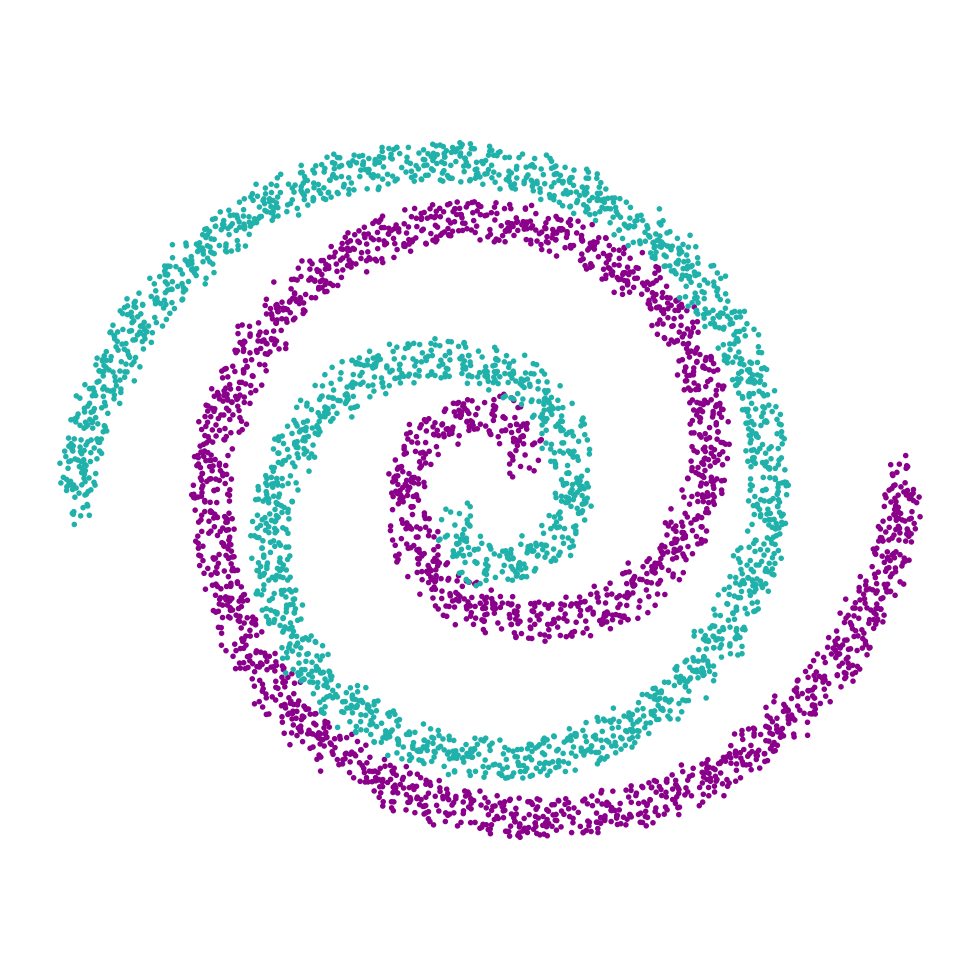

In [90]:
X, Y = spiral_dataset(n_samples=5_000, noise=20, n_rotations=2)

colormap = colors.ListedColormap(["darkmagenta", "lightseagreen"])

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap=colormap)
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.axis("off")
plt.axis("equal")
plt.tight_layout()

# Utility functions

The following two cells contain the definitions of utility functions that we use later to visualise the decision boundaries and "zones" of the trained model.

In [91]:
def get_grid_predictions(model: torch.nn.Module) -> Tuple[np.ndarray, np.ndarray, torch.Tensor]:
    """
    Generates a 200x200 grid of 2d points on which we will perform inference
    with the trained classifier. The resulting predicted labels will then be
    used to draw a contour plot (not in this function) showing the decision
    boundary.


    Parameters
    ----------
    model : torch.nn.Module
        Trained classifier.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, torch.Tensor]
        Grid point x-values, y-values, and model predictions for those points.
    """
    xs, ys = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
    grid_points = np.column_stack((xs.ravel(), ys.ravel())).astype(np.float32)

    model.eval()
    with torch.no_grad():
        grid_preds = model(torch.from_numpy(grid_points))

    grid_preds = grid_preds.argmax(axis=1)
    return xs, ys, grid_preds

In [92]:
def create_contour_plot(
        xs: np.ndarray,
        ys: np.ndarray,
        grid_preds: torch.Tensor,
        file_name: str|None = None, epoch: int|None = None
    ):
    """
    Creates a contour plot using the classifier predictions on a regular grid of
    points. This function can be called inside the training loop, in which case
    it expects `file_name` and `epoch` arguments, and will write the plot to
    disk. If these last two arguments are `None`, then the plot is just shown in
    this Jupyter notebook but not written to disk.

    Parameters
    ----------
    xs : np.ndarray
        x-coordinates of grid points
    ys : np.ndarray
        y-coordinates of grid points
    grid_preds : torch.Tensor
        Label predictions for grid points
    file_name : str | None, optional
       File path in case the plot should be saved to disk, by default None
    epoch : int | None, optional
        Epoch, used as plot title, by default None
    """
    plt.figure(figsize=(5, 5), dpi=200)

    if epoch is not None:
        plt.title(f"Epoch {epoch}")
    plt.contourf(xs, ys, grid_preds.reshape(xs.shape), cmap=colormap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=1, cmap=colormap)
    plt.axis("equal")
    plt.xlim(-2.3, 2.3)
    plt.ylim(-2.3, 2.3)
    plt.axis("off")
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(file_name)
        
        # Clear memory
        plt.close()
        plt.clf()
        plt.cla()
        plt.close("all")

## Spiral Classifier Model

In [93]:
class SpiralClassifier(nn.Module):
    def __init__(
            self,
            input_shape: int,
            output_shape: int,
            n_inner_layers: int,
            width: int = 8
        ):
        super(SpiralClassifier, self).__init__()
        
        layers = [
            nn.Linear(input_shape, width),
            nn.ReLU()
        ]
        
        for _ in range(n_inner_layers):
            layers.extend([nn.Linear(width, width), nn.ReLU()])
        
        layers.append(nn.Linear(width, output_shape))
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.layers(x)
        return nn.functional.softmax(logits, dim=1)

# Create Dataset and Train/Eval Split

In [94]:
n_samples   = 20_000
noise       = 20
n_rotations = 2
batch_size  = 512
train_split = 0.8  # We use 80% of the data for training, 20% for evaluation

# Generate spiral dataset
dataset = SpiralDataset(n_samples, noise, n_rotations)
    
# Calculate the sizes of the train and eval dataset
train_size = int(train_split * len(dataset))
eval_size  = len(dataset) - train_size

# Split the dataset
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(eval_dataset,  batch_size=batch_size, shuffle=False)

# Train Spiral Classifier

In [95]:
n_epochs      = 500
lr            = 1e-4
loss_function = nn.CrossEntropyLoss()
model         = SpiralClassifier(2, 2, n_inner_layers=4, width=16)
optimizer     = torch.optim.Adam(model.parameters(), lr=lr)

# Initialise lists used for tracking loss and accuracy
train_losses     = []
eval_losses      = []
train_accuracies = []
eval_accuracies  = []

In [96]:
# Initialize tqdm progress bar for epochs
epoch_bar = tqdm(range(1, n_epochs+1), desc="Epoch")

for epoch in epoch_bar:
    # Training
    model.train()
    train_loss = 0
    train_accuracy = 0
    train_batches = 0
    for x, y in train_loader:
        # Forward pass
        preds = model(x)
        loss = loss_function(preds, y)
        train_loss += loss.item()

        # Calculate batch accuracy
        accuracy = (preds.argmax(1) == y).type(torch.float).mean().item()
        train_accuracy += accuracy

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_batches += 1

    avg_train_loss = train_loss / train_batches
    avg_train_accuracy = train_accuracy / train_batches

    # Evaluation
    model.eval()
    eval_loss = 0
    eval_accuracy = 0
    eval_batches = 0
    with torch.no_grad():
        for x, y in eval_loader:
            preds = model(x)

            # Calculate batch loss
            loss = loss_function(preds, y)
            eval_loss += loss.item()

            # Calculate batch accuracy
            accuracy = (preds.argmax(1) == y).type(torch.float).mean().item()
            eval_accuracy += accuracy

            eval_batches += 1

    avg_eval_loss = eval_loss / eval_batches
    avg_eval_accuracy = eval_accuracy / eval_batches

    # Record training history
    train_losses.append(avg_train_loss)
    eval_losses.append(avg_eval_loss)
    train_accuracies.append(avg_train_accuracy)
    eval_accuracies.append(avg_eval_accuracy)

    # Create contour plot of current decision boundary
    # xs, ys, grid_preds = get_grid_predictions(model)
    # create_contour_plot(xs, ys, grid_preds, file_name=f"epoch_{epoch}.png", epoch=epoch)

    # Update tqdm description with current metrics
    epoch_bar.set_description(f"Train loss: {avg_train_loss:.3f} - Train acc: {100*avg_train_accuracy:.2f}% - Eval loss: {avg_eval_loss:.3f} - Eval acc: {100*avg_eval_accuracy:.2f}%")

Train loss: 0.328 - Train acc: 98.75% - Eval loss: 0.330 - Eval acc: 98.56%: 100%|██████████| 500/500 [00:35<00:00, 13.92it/s]


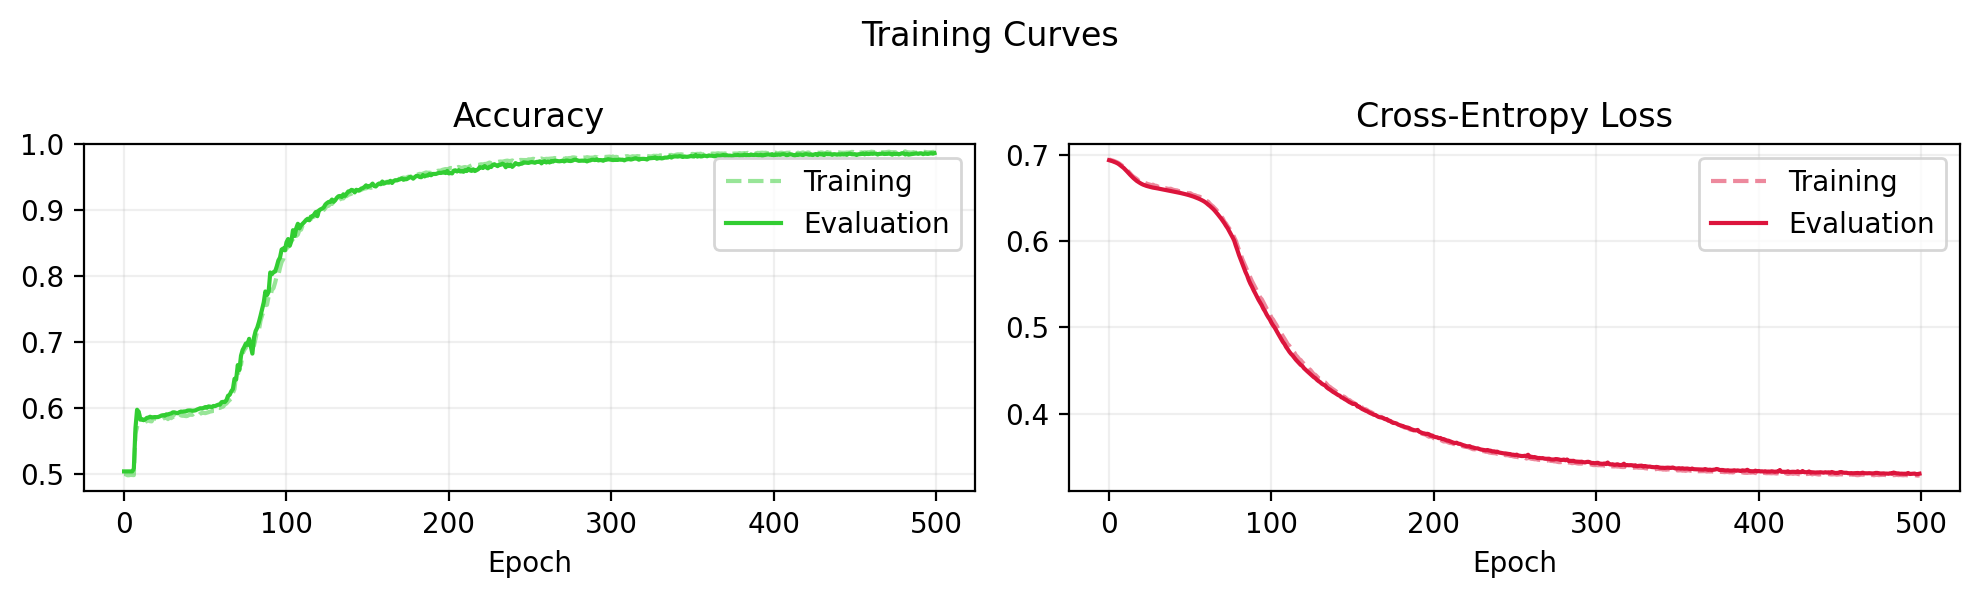

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)

plt.suptitle("Training Curves")
ax[0].set_title("Accuracy")
ax[0].plot(train_accuracies, c="limegreen", label="Training", ls="--", alpha=0.5)
ax[0].plot(eval_accuracies,  c="limegreen", label="Evaluation")
ax[0].set_ylim(None, 1)
ax[0].set_xlabel("Epoch")
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(train_losses, c="crimson", label="Training", ls="--", alpha=0.5)
ax[1].plot(eval_losses,  c="crimson", label="Evaluation")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Cross-Entropy Loss")
ax[1].grid(alpha=0.2)
ax[1].legend()

plt.tight_layout()

# Visualise decision boundary of the trained classifier 

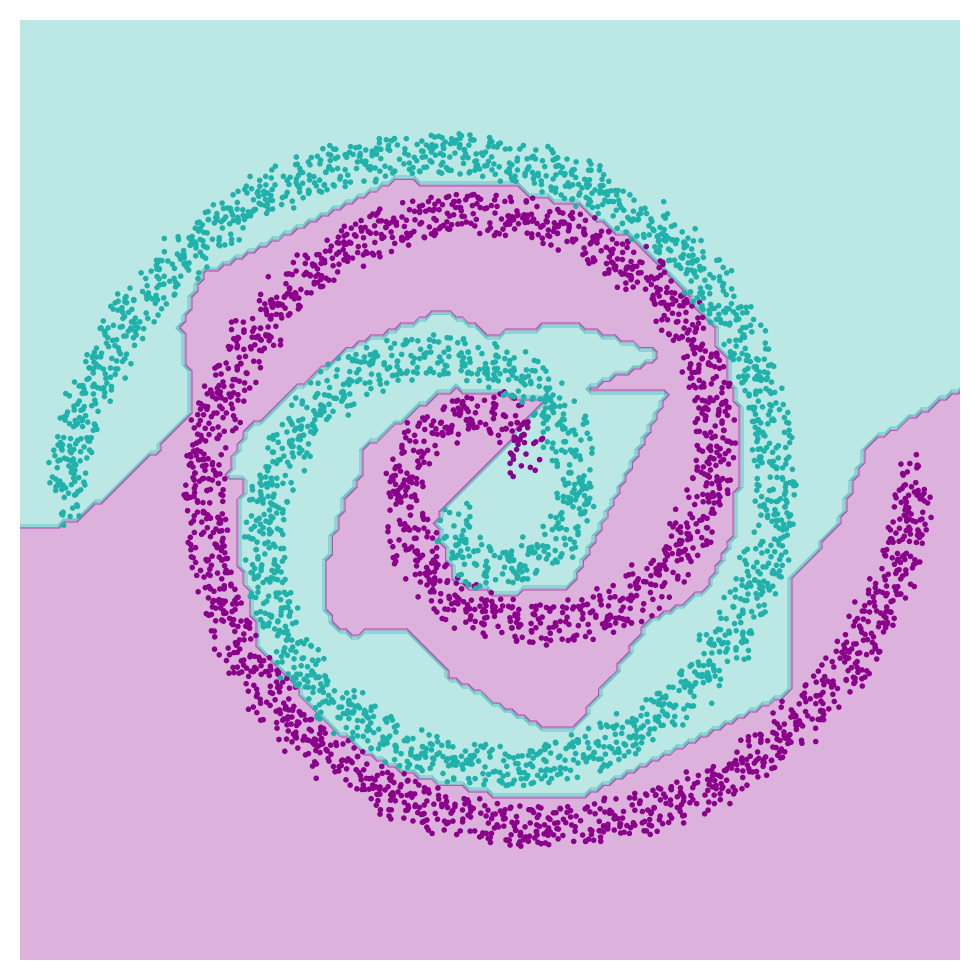

In [98]:
xs, ys, grid_preds = get_grid_predictions(model)
create_contour_plot(xs, ys, grid_preds)